In [1]:
from main import *
import numpy as np

# parameter setup

In [2]:
target_feature = "merged_support3_variance_0.1_random_1M"
target_feature_suffix = "_matrix.npy"
save_data_path = "./results"

select_methods = ["rf"]# ["random", "xgb", "rf", "variance", "chi2", "f_classif"] # Extra-trees # "mutual_info_classif"
    
n_select_list = [256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072] #5105448
n_dim_reduce_list = [128, 256, 512, 1024, None]  ## list should always contain None to perform whole feature training after selection
ML_models = ["SVM"] #["SVM", "XGB", "RF", "DT", "KNN"]

# data loading

In [3]:
feature_data_path, sample_annotation_file = get_data_path(save_data_path)

dataset = data_loader(os.path.join(feature_data_path, target_feature + target_feature_suffix), 
                        sample_annotation_file)
(X, y_original, y), (train_indices, val_indices, test_indices), label_mapping = dataset.get_data()


result_combined = []

2024-05-10 11:41:15,360 - INFO - [progress] Read data done. X.shape: (3202, 1048576), y.shape: (3202,)
2024-05-10 11:41:28,337 - INFO - [progress] Dropped 709 samples from the dataset. X.shape: (2493, 1048576), y.shape: (2493,)
2024-05-10 11:41:28,641 - INFO -  - Data_split: train_set (n= 1495), val_set (n= 499), test_set (n= 499)


# feature selection

# hyperparam optimization

In [6]:
import optuna

def objective(trial, X_train, y_train, X_val, y_val, method):
    if method == "SVM":
        C = trial.suggest_loguniform('C', 1e-6, 10)  # Log-uniform distribution for C
        kernel = "linear"
        gamma = 'scale'
        
        # kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid'])  # Categorical distribution for kernel type
        # if kernel == 'rbf' or kernel == 'sigmoid':
        #     gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])  # Categorical for gamma if relevant
        # else:
        #     gamma = 'scale'  # Default to 'scale' for linear to avoid irrelevance
        model = SVC(C=C, kernel=kernel, gamma=gamma, random_state=RANDOM_SEED)
        
    elif method == "RF":
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
        max_depth = trial.suggest_int('max_depth', 10, 100, step=10)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        model = RandomForestClassifier(
            n_estimators=n_estimators, max_depth=max_depth,
            min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
            random_state=RANDOM_SEED)
    elif method == "XGB":
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1)
        n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
        max_depth = trial.suggest_int("max_depth", 3, 10)
        gamma = trial.suggest_float("gamma", 0.1, 1.0, step=0.1)
        subsample = trial.suggest_float("subsample", 0.6, 1.0, step=0.1)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0, step=0.1)
        model = XGBClassifier(
            learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth,
            gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree,
            objective='multi:softmax', num_class=len(np.unique(y_train)),
            use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_SEED)
    
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    train_accuracy = accuracy_score(y_train, y_pred_train)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    trial.set_user_attr("train_accuracy", train_accuracy)
    return val_accuracy

def visualize_study(study):
    optuna.visualization.matplotlib.plot_optimization_history(study)
    plt.show()

    optuna.visualization.matplotlib.plot_parallel_coordinate(study)
    plt.show()

    # Additional plotting can be customized based on user's needs.
    # For instance, plot train vs validation accuracy:
    train_accuracies = [trial.user_attrs["train_accuracy"] for trial in study.trials]
    val_accuracies = [trial.value for trial in study.trials]

    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Trial')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.show()

In [10]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, X_train_reduced, y_train, X_val_reduced, y_val, method=train_model), n_trials=50)

best_rf_params = study.best_trial.params
print("Best RF Params:", best_rf_params)

[I 2024-04-25 12:42:41,809] A new study created in memory with name: no-name-313d29cb-a3b9-43d0-bd06-e1df2461937c
[I 2024-04-25 12:42:42,300] Trial 0 finished with value: 0.30625 and parameters: {'C': 1.6028317765211449e-06}. Best is trial 0 with value: 0.30625.
[I 2024-04-25 12:42:42,609] Trial 1 finished with value: 0.81875 and parameters: {'C': 1.0848261240047883}. Best is trial 1 with value: 0.81875.
[I 2024-04-25 12:42:43,022] Trial 2 finished with value: 0.5796875 and parameters: {'C': 6.518372481490973e-06}. Best is trial 1 with value: 0.81875.
[I 2024-04-25 12:42:43,329] Trial 3 finished with value: 0.81875 and parameters: {'C': 0.13530983582546405}. Best is trial 1 with value: 0.81875.
[I 2024-04-25 12:42:43,659] Trial 4 finished with value: 0.83125 and parameters: {'C': 0.0003065399495574427}. Best is trial 4 with value: 0.83125.
[I 2024-04-25 12:42:43,979] Trial 5 finished with value: 0.8328125 and parameters: {'C': 0.00013585350423821874}. Best is trial 5 with value: 0.8328

Best RF Params: {'C': 0.00010150121394759344}


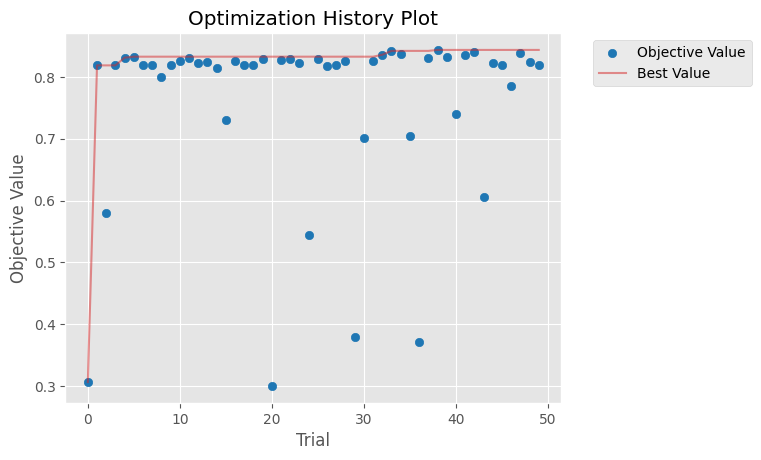

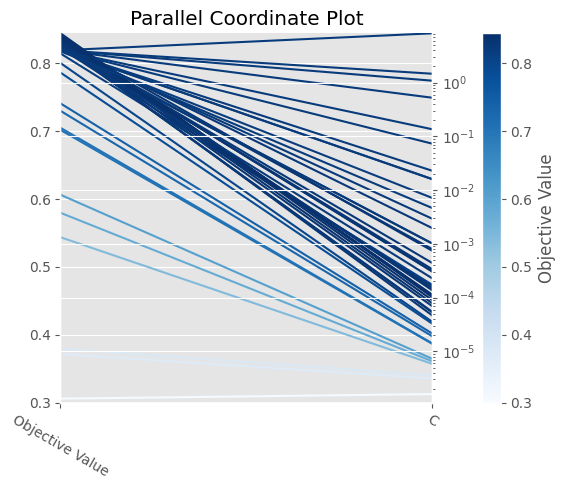

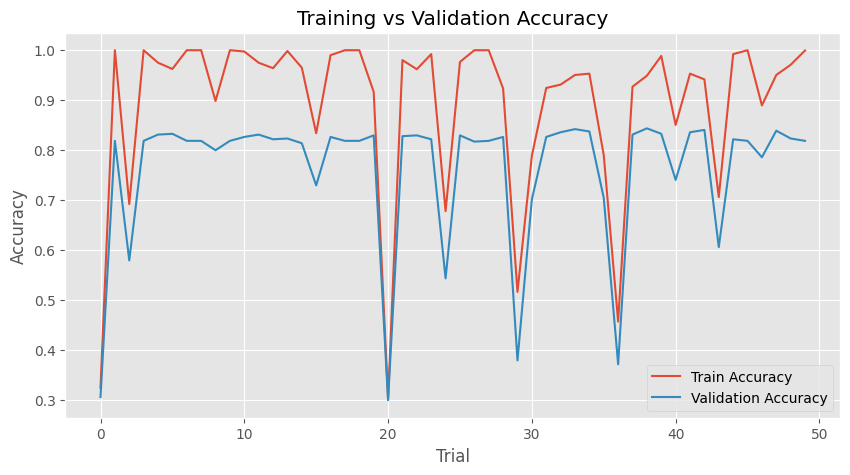

In [11]:
visualize_study(study)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
fi = np.load("1048576_seed42_xgb_basic_feature_importance_mean.npy")
fi = fi[np.argsort(fi)]

In [3]:
fi[-50:]

array([0.00188916, 0.00189694, 0.00193225, 0.00194109, 0.00197083,
       0.00198472, 0.00199865, 0.00201012, 0.0020278 , 0.00204058,
       0.0020527 , 0.00206112, 0.00211442, 0.00219885, 0.00220537,
       0.00221122, 0.00224201, 0.00226805, 0.00229387, 0.00230592,
       0.00234538, 0.00235614, 0.00236061, 0.00236602, 0.00240154,
       0.00243037, 0.00246651, 0.00251561, 0.00253385, 0.00257648,
       0.00264958, 0.00277211, 0.00303323, 0.00308287, 0.00309251,
       0.00312545, 0.00318943, 0.00322077, 0.00323402, 0.00338596,
       0.00351405, 0.00356735, 0.00379254, 0.00404007, 0.00404696,
       0.00425032, 0.00498451, 0.00510305, 0.0055974 , 0.00631185],
      dtype=float32)

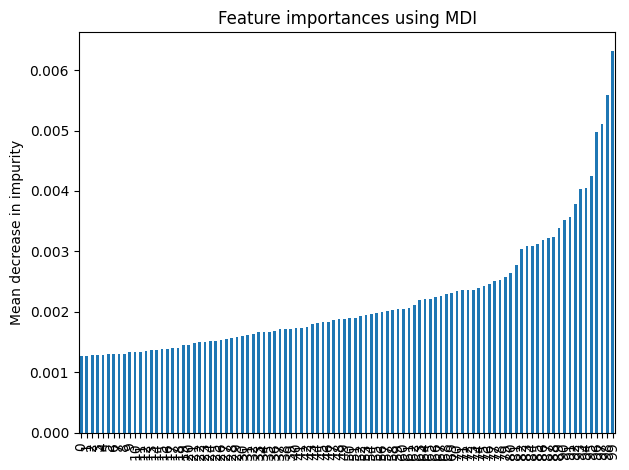

In [4]:
fig, ax = plt.subplots()
pd.Series(fi[-100:]).plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

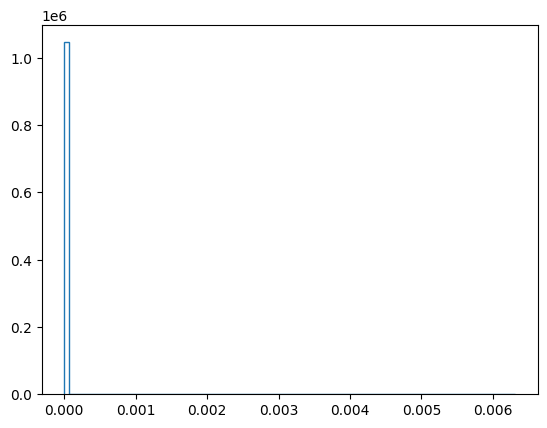

In [16]:
counts, bins = np.histogram(fi, bins = 100)
plt.stairs(counts, bins)

In [18]:
counts

array([1045830,     990,     505,     286,     199,     125,     111,
            85,      56,      60,      39,      29,      26,      33,
            20,      19,      18,      21,      10,      13,      10,
             8,       3,       4,       5,       4,       4,       6,
             4,       4,       3,       4,       4,       1,       2,
             3,       2,       4,       2,       2,       2,       1,
             0,       1,       0,       0,       0,       0,       3,
             1,       1,       2,       0,       1,       0,       1,
             1,       0,       0,       0,       1,       0,       0,
             0,       2,       0,       0,       1,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       1,       0,       1,       0,       0,       0,
             0,       0,       0,       0,       1,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,     